<a href="https://colab.research.google.com/github/MrBaten/AutoML/blob/main/brightness_augmentation_inception__v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import zipfile
zip_file_path = '/content/drive/MyDrive/Pest.zip'

# Specify the destination directory to extract the contents
destination_path = '/content/'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_path)


In [ ]:
import keras,os
import numpy as np
import tensorflow as tf
import cv2
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential , load_model , Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from tensorflow.keras import applications
from tensorflow.keras import optimizers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import load_img, img_to_array
from keras.layers import BatchNormalization
from glob import glob
from tensorflow.keras.applications.inception_v3 import preprocess_input
# Step 1: Prepare your dataset
# Assume you have a directory with images and corresponding labels

with tf.device('/gpu:0'):
    pass

train_dir = '/content/pest/train'
valid_dir = '/content/pest/test'

In [ ]:
# Preprocessing and data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=15,       # Apply rotation augmentation with a range of 15 degrees
    #horizontal_flip=True,    # Apply horizontal flip augmentation
    #width_shift_range=0.1,    # Apply width shift augmentation
    #height_shift_range=0.1,   # Apply height shift augmentation
   # shear_range=0.2,          # Apply shear augmentation
    #zoom_range=0.2,           # Apply zoom augmentation
    brightness_range=[0.1, 1.2],  # Apply brightness augmentation with a range [0.8, 1.2]
    #contrast_range=[0.8, 1.2],    # Apply contrast augmentation with a range [0.8, 1.2]
    fill_mode='nearest'       # Filling mode for filling empty spaces after augmentation
)

# Preprocessing for test data (only rescaling, no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 254
val_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(224,224),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical"
                )

val_generator = val_datagen.flow_from_directory(
                valid_dir,
                target_size=(224,224),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical"
                )

Found 2700 images belonging to 9 classes.
Found 450 images belonging to 9 classes.


In [ ]:
# Initialize empty lists to store the data and labels
train_x = []
train_y = []
test_x = []
test_y = []

# Iterate over the training data generator and collect all batches
for train_batch_x, train_batch_y in train_generator:
    train_x.append(train_batch_x)
    train_y.append(train_batch_y)

    # Check if we have collected all samples
    if len(train_x) * train_generator.batch_size >= len(train_generator.filenames):
        break

# Concatenate the batches to form the complete training dataset
train_x = np.concatenate(train_x, axis=0)
train_y = np.concatenate(train_y, axis=0)

# Iterate over the test data generator and collect all batches
for test_batch_x, test_batch_y in val_generator:
    test_x.append(test_batch_x)
    test_y.append(test_batch_y)

    # Check if we have collected all samples
    if len(test_x) * val_generator.batch_size >= len(val_generator.filenames):
        break

# Concatenate the batches to form the complete test dataset
test_x = np.concatenate(test_x, axis=0)
test_y = np.concatenate(test_y, axis=0)

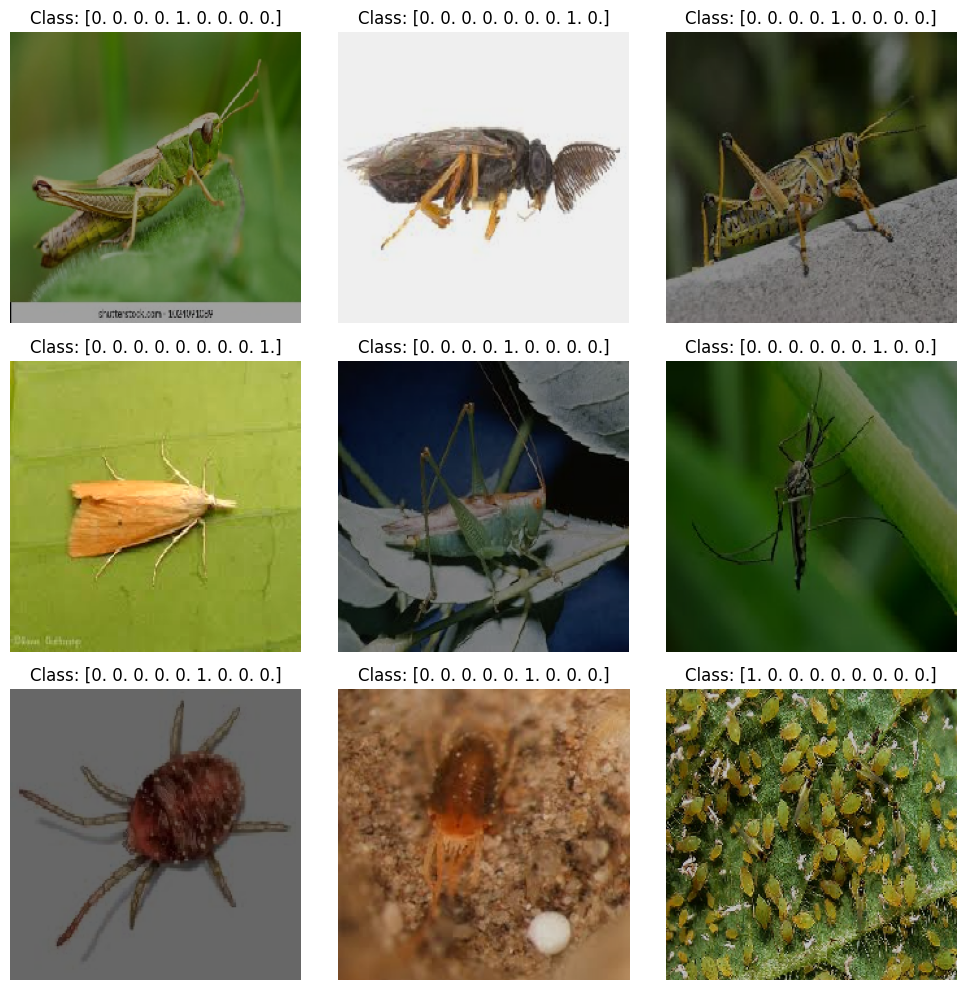

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a train_data_gen and test_data_gen
# train_data_gen and test_data_gen should be instances of ImageDataGenerator

# Get a batch of images and labels from the training data generator
batch_images, batch_labels = next(train_generator)

# Assuming batch_images is a batch of images in the shape (batch_size, image_height, image_width, channels)
batch_images_rgb = (batch_images * 255).astype(int)
# Define a function to plot a grid of images
def plot_images(images, labels, num_rows=3, num_cols=3):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10,10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"Class: {labels[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plot the batch of images
plot_images(batch_images_rgb, batch_labels)

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2700, 224, 224, 3)
(2700, 9)
(450, 224, 224, 3)
(450, 9)


In [ ]:
IncV3 = InceptionV3(include_top = False, weights = "imagenet",input_shape = (224,224,3))

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
className = glob(train_dir + "/*")
NumberofClass = len(className)
print("NumberofClass:", NumberofClass)

NumberofClass: 9


In [ ]:
model = Sequential()

model.add(IncV3)

for layer in model.layers:
    layer.trainable = False


model.add(Flatten())

model.add(Dense(units = 2048, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(units = NumberofClass, activation = "softmax"))


In [ ]:
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
history = model.fit(train_x, train_y, batch_size=32, epochs=40, validation_data=(test_x, test_y))

Epoch 1/40
85/85 [==============================] - 31s 160ms/step - loss: 16.1402 - accuracy: 0.6570 - val_loss: 0.9907 - val_accuracy: 0.9422
Epoch 2/40
85/85 [==============================] - 8s 98ms/step - loss: 0.6853 - accuracy: 0.9226 - val_loss: 0.5170 - val_accuracy: 0.9533
Epoch 3/40
85/85 [==============================] - 9s 108ms/step - loss: 0.3208 - accuracy: 0.9474 - val_loss: 0.4086 - val_accuracy: 0.9644
Epoch 4/40
85/85 [==============================] - 9s 101ms/step - loss: 0.1908 - accuracy: 0.9644 - val_loss: 0.5527 - val_accuracy: 0.9622
Epoch 5/40
85/85 [==============================] - 9s 101ms/step - loss: 0.1364 - accuracy: 0.9733 - val_loss: 0.4743 - val_accuracy: 0.9511
Epoch 6/40
85/85 [==============================] - 9s 109ms/step - loss: 0.1177 - accuracy: 0.9756 - val_loss: 0.5089 - val_accuracy: 0.9667
Epoch 7/40
85/85 [==============================] - 9s 103ms/step - loss: 0.2335 - accuracy: 0.9641 - val_loss: 0.8143 - val_accuracy: 0.9644
Epoch

In [ ]:
train_loss, train_accuracy = model.evaluate(train_generator)
test_loss, test_accuracy = model.evaluate(val_generator)

print('Training Accuracy:', train_accuracy)
print('Test Accuracy:', test_accuracy)

2/2 [==============================] - 9s 7s/step - loss: 2.0746 - accuracy: 0.9711
Training Accuracy: 0.9911110997200012
Test Accuracy: 0.9711111187934875


In [ ]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

15/15 [==============================] - 1s 74ms/step - loss: 2.0746 - accuracy: 0.9711
Loss = 2.0746445655822754
Test Accuracy = 0.9711111187934875


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model.evaluate(test_x, test_y)
pred_labels = np.argmax(model.predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(9):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, pos_label=class_label, average='macro')
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, pos_label=class_label, average='macro')
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, pos_label=class_label, average='macro')
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("F1 Score:", f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)

15/15 [==============================] - 2s 74ms/step
Mean Class Accuracy: 0.9711111111111111
F1 Score: 0.7117619874515335
Mean Average Precision: 0.7166666666666667
Mean Average Recall: 0.7072222222222222


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a 

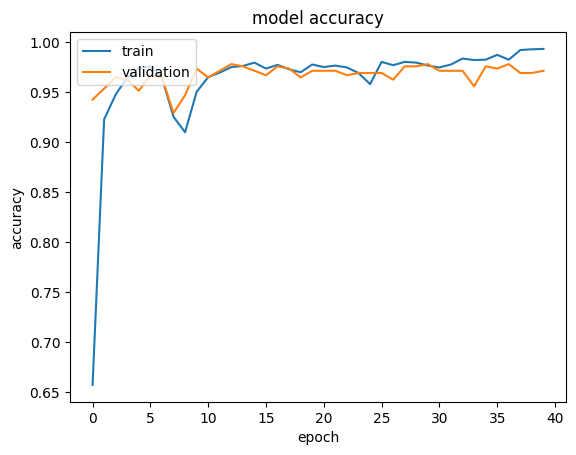

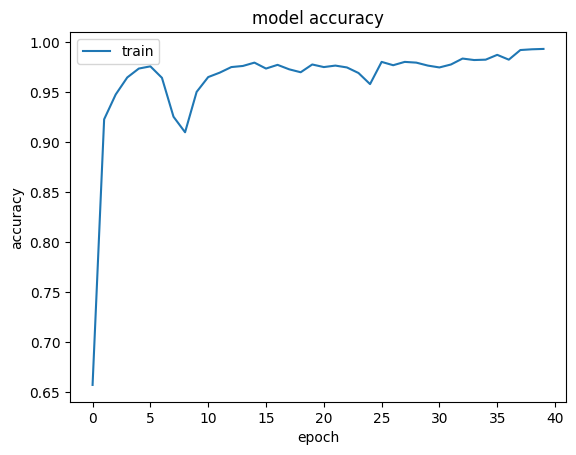

In [ ]:

def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

def plot_hist(history):
    plt.plot(history.history["accuracy"])
    #plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

SGD


In [ ]:
model.compile(optimizer = "SGD", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
history = model.fit(train_x, train_y, batch_size=32, epochs=40, validation_data=(test_x, test_y))

Epoch 1/40
85/85 [==============================] - 15s 122ms/step - loss: 6.7079 - accuracy: 0.9630 - val_loss: 10.8128 - val_accuracy: 0.9711
Epoch 2/40
85/85 [==============================] - 8s 95ms/step - loss: 0.9878 - accuracy: 0.9852 - val_loss: 9.0758 - val_accuracy: 0.9733
Epoch 3/40
85/85 [==============================] - 8s 97ms/step - loss: 0.4142 - accuracy: 0.9933 - val_loss: 8.0020 - val_accuracy: 0.9689
Epoch 4/40
85/85 [==============================] - 8s 99ms/step - loss: 0.1856 - accuracy: 0.9948 - val_loss: 7.3396 - val_accuracy: 0.9800
Epoch 5/40
85/85 [==============================] - 8s 99ms/step - loss: 0.2331 - accuracy: 0.9959 - val_loss: 7.4471 - val_accuracy: 0.9733
Epoch 6/40
85/85 [==============================] - 8s 96ms/step - loss: 0.4058 - accuracy: 0.9952 - val_loss: 7.3025 - val_accuracy: 0.9778
Epoch 7/40
85/85 [==============================] - 8s 98ms/step - loss: 0.1616 - accuracy: 0.9963 - val_loss: 8.3954 - val_accuracy: 0.9711
Epoch 8/40

In [ ]:
train_loss, train_accuracy = model.evaluate(train_generator)
test_loss, test_accuracy = model.evaluate(val_generator)

print('Training Accuracy:', train_accuracy)
print('Test Accuracy:', test_accuracy)

2/2 [==============================] - 2s 478ms/step - loss: 8.3975 - accuracy: 0.9733
Training Accuracy: 0.9944444298744202
Test Accuracy: 0.9733333587646484


In [ ]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

15/15 [==============================] - 1s 70ms/step - loss: 8.3975 - accuracy: 0.9733
Loss = 8.397521018981934
Test Accuracy = 0.9733333587646484


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model.evaluate(test_x, test_y)
pred_labels = np.argmax(model.predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(9):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, pos_label=class_label, average='macro')
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, pos_label=class_label, average='macro')
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, pos_label=class_label, average='macro')
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("F1 Score:", f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)

15/15 [==============================] - 2s 72ms/step
Mean Class Accuracy: 0.9733333333333333
F1 Score: 0.7644464010978703
Mean Average Precision: 0.7685185185185185
Mean Average Recall: 0.7607407407407407


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a 

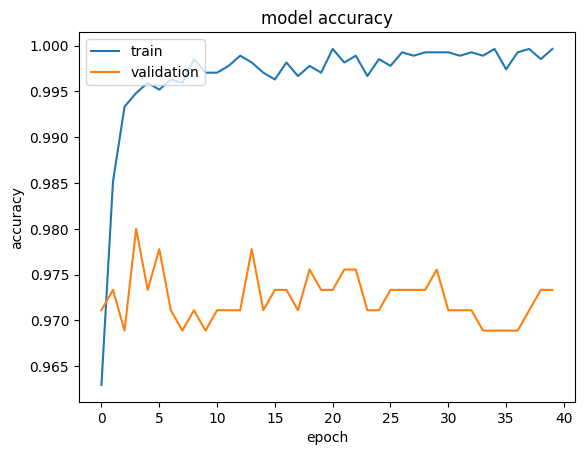

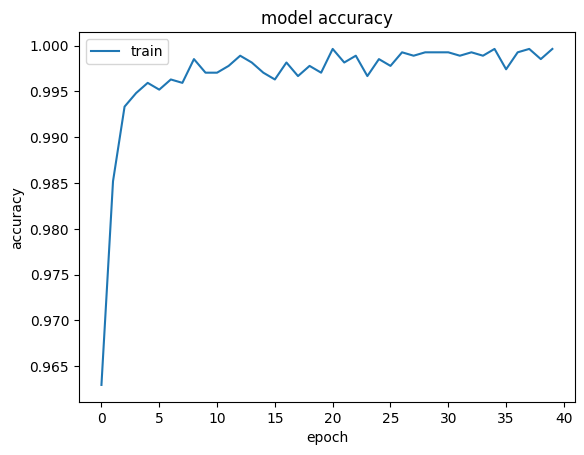

In [ ]:

def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

def plot_hist(history):
    plt.plot(history.history["accuracy"])
    #plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

RMS_prop

In [ ]:
from tensorflow.keras.optimizers import RMSprop

In [ ]:
model.compile(optimizer = "RMSprop", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
history = model.fit(train_x, train_y, batch_size=32, epochs=40, validation_data=(test_x, test_y))

Epoch 1/40
85/85 [==============================] - 16s 121ms/step - loss: 0.1823 - accuracy: 0.9959 - val_loss: 9.9986 - val_accuracy: 0.9644
Epoch 2/40
85/85 [==============================] - 8s 99ms/step - loss: 0.4193 - accuracy: 0.9970 - val_loss: 11.9866 - val_accuracy: 0.9689
Epoch 3/40
85/85 [==============================] - 8s 97ms/step - loss: 0.1832 - accuracy: 0.9970 - val_loss: 9.8951 - val_accuracy: 0.9756
Epoch 4/40
85/85 [==============================] - 8s 98ms/step - loss: 0.1139 - accuracy: 0.9974 - val_loss: 12.5827 - val_accuracy: 0.9689
Epoch 5/40
85/85 [==============================] - 8s 99ms/step - loss: 0.4378 - accuracy: 0.9933 - val_loss: 8.0868 - val_accuracy: 0.9756
Epoch 6/40
85/85 [==============================] - 8s 99ms/step - loss: 0.1764 - accuracy: 0.9974 - val_loss: 10.2819 - val_accuracy: 0.9733
Epoch 7/40
85/85 [==============================] - 8s 96ms/step - loss: 0.2606 - accuracy: 0.9963 - val_loss: 9.7561 - val_accuracy: 0.9711
Epoch 8/

In [ ]:
train_loss, train_accuracy = model.evaluate(train_generator)
test_loss, test_accuracy = model.evaluate(val_generator)

print('Training Accuracy:', train_accuracy)
print('Test Accuracy:', test_accuracy)

2/2 [==============================] - 2s 396ms/step - loss: 6.4700 - accuracy: 0.9800
Training Accuracy: 0.9948148131370544
Test Accuracy: 0.9800000190734863


In [ ]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

15/15 [==============================] - 1s 69ms/step - loss: 6.4699 - accuracy: 0.9800
Loss = 6.469902038574219
Test Accuracy = 0.9800000190734863


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model.evaluate(test_x, test_y)
pred_labels = np.argmax(model.predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(9):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, pos_label=class_label, average='macro')
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, pos_label=class_label, average='macro')
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, pos_label=class_label, average='macro')
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("F1 Score:", f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)

15/15 [==============================] - 2s 73ms/step
Mean Class Accuracy: 0.98
F1 Score: 0.7968866062077815
Mean Average Precision: 0.8
Mean Average Recall: 0.794


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a 

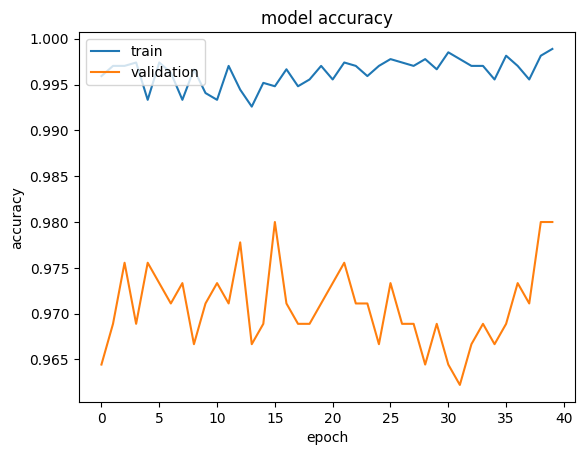

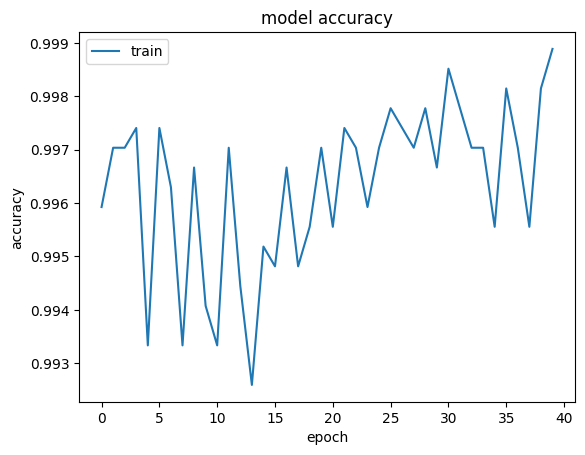

In [ ]:

def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

def plot_hist(history):
    plt.plot(history.history["accuracy"])
    #plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

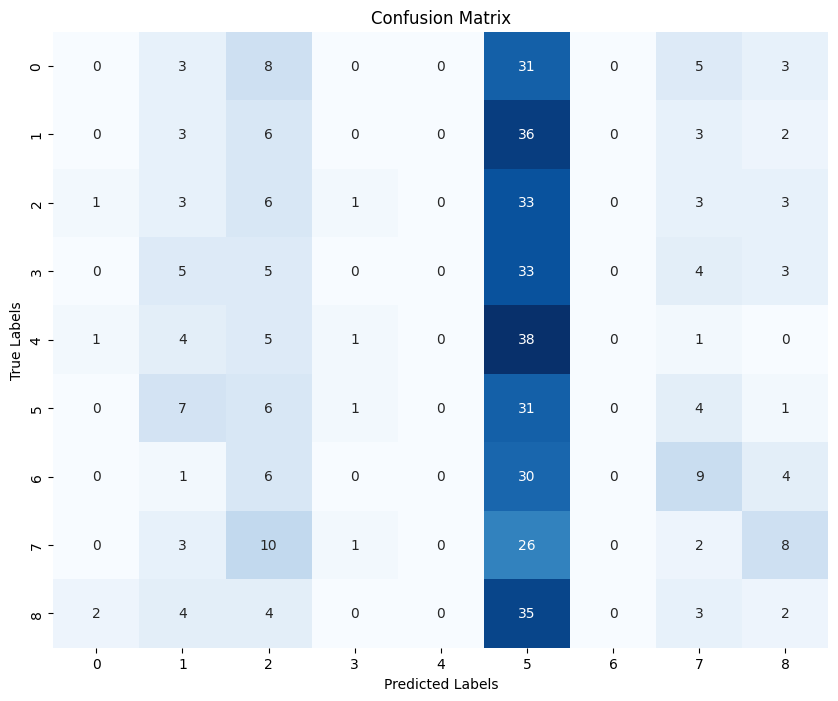

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

we use adam optimizer

In [ ]:
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = 40,
                    batch_size = batch_size)

Epoch 1/40
11/11 [==============================] - 54s 3s/step - loss: 20.0888 - accuracy: 0.1430 - val_loss: 15.2246 - val_accuracy: 0.1089
Epoch 2/40
11/11 [==============================] - 18s 2s/step - loss: 5.2909 - accuracy: 0.1911 - val_loss: 14.1737 - val_accuracy: 0.1111
Epoch 3/40
11/11 [==============================] - 23s 2s/step - loss: 2.0312 - accuracy: 0.3359 - val_loss: 10.2731 - val_accuracy: 0.1111
Epoch 4/40
11/11 [==============================] - 21s 2s/step - loss: 1.6476 - accuracy: 0.4326 - val_loss: 12.0751 - val_accuracy: 0.1089
Epoch 5/40
11/11 [==============================] - 19s 2s/step - loss: 1.4679 - accuracy: 0.4941 - val_loss: 13.6554 - val_accuracy: 0.1089
Epoch 6/40
11/11 [==============================] - 19s 2s/step - loss: 1.3317 - accuracy: 0.5596 - val_loss: 14.9994 - val_accuracy: 0.1089
Epoch 7/40
11/11 [==============================] - 19s 2s/step - loss: 1.2193 - accuracy: 0.6096 - val_loss: 15.8729 - val_accuracy: 0.1089
Epoch 8/40
1

In [ ]:
train_loss, train_accuracy = model.evaluate(train_generator)
test_loss, test_accuracy = model.evaluate(val_generator)

print('Training Accuracy:', train_accuracy)
print('Test Accuracy:', test_accuracy)

NameError: ignored

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score
# Get the predicted labels for the validation data
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels for the validation data
y_true = val_generator.labels

# Calculate the F1 score
f1 = classification_report(y_true, y_pred_classes)
print(f1)

2/2 [==============================] - 3s 1s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        50
           2       0.10      0.74      0.18        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50
           5       0.07      0.04      0.05        50
           6       0.00      0.00      0.00        50
           7       0.07      0.02      0.03        50
           8       0.10      0.10      0.10        50

    accuracy                           0.10       450
   macro avg       0.04      0.10      0.04       450
weighted avg       0.04      0.10      0.04       450



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
precision = precision_score(y_true, y_pred_classes, average='macro')
print(precision)

0.038758949272592935


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
recall = recall_score(y_true, y_pred_classes, average='macro')
print(recall)

0.1


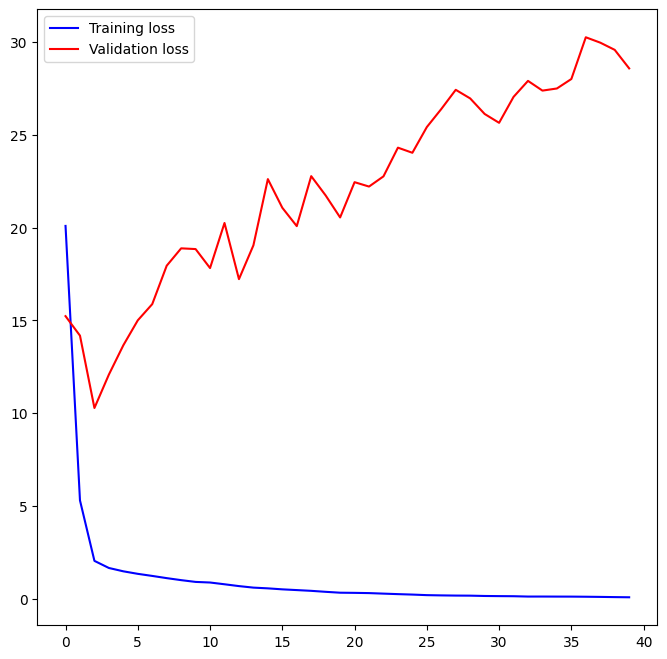

<Figure size 640x480 with 0 Axes>

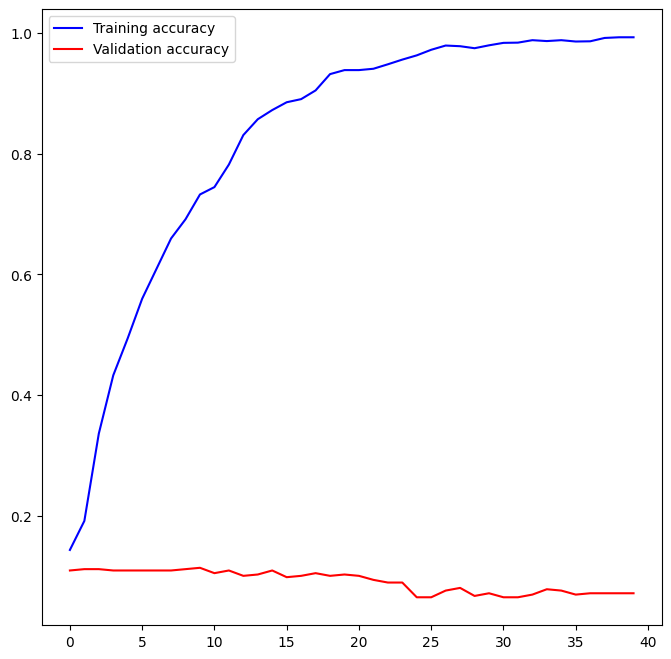

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.show()